## Imports and Downloading the Data

In [1]:
! pip install torcheval streamlit -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 74.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.1 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import numpy as np   # linear algebra
import matplotlib.pyplot as plt   # data visualization
from tqdm.notebook import tqdm   # progress bar
import time  
import math
from colorama import Fore, Style   # pretty print
import pickle   # saving the model
import streamlit as st   # deploying the model

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torcheval.metrics.functional import multiclass_accuracy
import timm   # model library

In [3]:
! python --version

Python 3.10.12


In [4]:
# for documentation
print("PyTorch version : ", torch.__version__)
print("Torchvision version : ", torchvision.__version__)
print("Numpy version : ", np.__version__)
print("Timm version : ", timm.__version__)

PyTorch version :  2.5.1+cu121
Torchvision version :  0.20.1+cu121
Numpy version :  1.26.4
Timm version :  1.0.12


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Defining Dataset and DataLoaders

In [9]:
class BloodCellDataset(Dataset):

    # mandatory properties
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    # additional properties
    def classes(self):
        return self.data.classes

    def show_image(self, idx):
        tensor, label = self.data[idx]
        img = to_pil_image(tensor)
        return img

In [10]:
# Defining Transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),   # original is 240 x 240
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
])

In [11]:
begin = time.time()

DATA_DIR = "/kaggle/input/blood-cells-image-dataset/bloodcells_dataset"
dataset = BloodCellDataset(DATA_DIR, transform)

end = time.time()

In [12]:
print(f"Elapsed time for creating the BloodCellDataset object is {math.ceil(end - begin)} seconds.")   
# written out of curiosity

Elapsed time for creating the BloodCellDataset object is 19 seconds.


In [13]:
print("Number of instances in the dataset : ", dataset.__len__())

Number of instances in the dataset :  17092


In [14]:
# Checking Classes

num_classes = len(dataset.classes())
print(f"List of Classes : {dataset.classes()}")
print(f"Number of Classes : {num_classes}")

List of Classes : ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Number of Classes : 8


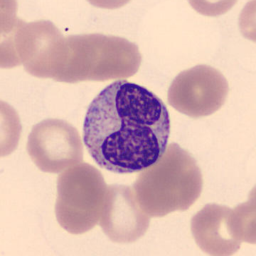

In [15]:
# Checking Images

img = dataset.show_image(6122)
img

In [16]:
# Splitting the Dataset

generator = torch.Generator().manual_seed(42)   # for reproductable results
fractions = [0.7, 0.1, 0.2]
train_ds, test_ds, val_ds = random_split(dataset, fractions, generator=generator)

In [17]:
print(f"Number of instances in the 'Train Split' : {train_ds.__len__()}")
print(f"Number of instances in the 'Test Split' : {test_ds.__len__()}")
print(f"Number of instances in the 'Validation Split' : {val_ds.__len__()}")

Number of instances in the 'Train Split' : 11965
Number of instances in the 'Test Split' : 1709
Number of instances in the 'Validation Split' : 3418


In [18]:
# Creating DataLoaders

batch_size = 128

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

## Building the PyTorch Model

In [19]:
class BloodCellClassifier(nn.Module):

    def __init__(self, arch, num_classes):    # components of our model
        super(BloodCellClassifier, self).__init__()
        self.base_model = timm.create_model(arch, pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])   
        # removing the last layer (classification head) because we have new data, therefore new num_of_classes
        
        effnet_out_size = 1280   # default out size for efficientnet_b0

        # new layers
        self.classifier = nn.Linear(effnet_out_size, num_classes)

    def forward(self, x):   # forward pass
        x = self.features(x)
        out = self.classifier(x)
        return out

    # prints train loss & accuracy and validation loss & accuracy
    def print_metrics(self, epoch, num_epochs, train_loss, val_loss, train_acc, val_acc, time, lr):
        print(f"{Fore.CYAN}{'='*65}{Style.RESET_ALL}")
        print(f"{Fore.YELLOW}Epoch {epoch+1}/{num_epochs}{Style.RESET_ALL} \t {Fore.BLUE}Elapsed Time: {time} seconds {Style.RESET_ALL} \t {Fore.WHITE}Learning Rate: {lr}{Style.RESET_ALL}")
        print(f"{Fore.RED}Train Loss      : {train_loss:.4f} \t Validation Loss      : {val_loss:.4f}{Style.RESET_ALL}")
        print(f"{Fore.GREEN}Train Accuracy  : {train_acc:.2f} \t Validation Accuracy  : {val_acc:.2f}{Style.RESET_ALL}")
        print(f"{Fore.CYAN}{'='*65}{Style.RESET_ALL}")

In [20]:
# creating the model
arch = "efficientnet_b0"
model = BloodCellClassifier(arch=arch, num_classes=num_classes)
model.to(device)
print(f"{arch} model has beed loaded into {device}")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

efficientnet_b0 model has beed loaded into cuda:0


## Training Loop

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience=3, cooldown=2)

In [35]:
# to prevent future errors

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [36]:
num_epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):

    begin = time.time()   # beginning time

    # Training Phase
    model.train()
    running_loss = 0.0

    # Single Epoch
    for images, labels in tqdm(train_loader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        
    train_loss = running_loss / train_loader.dataset.__len__()
    train_losses.append(train_loss)

    train_acc = multiclass_accuracy(outputs, labels)
    train_accs.append(train_acc)

    # Validation Phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation Loop"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
    val_loss = running_loss / val_loader.dataset.__len__()
    scheduler.step(val_loss)
    val_losses.append(val_loss)

    val_acc = multiclass_accuracy(outputs, labels)
    val_accs.append(val_acc)

    end = time.time()

    elapsed_time = math.ceil(end - begin)
    lr = optimizer.param_groups[0]["lr"]

    # Print Epoch Stats
    model.print_metrics(epoch, num_epochs, train_loss, val_loss, train_acc.item(), val_acc.item(), elapsed_time, lr)


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/10 	 Elapsed Time: 218 seconds  	 Learning Rate: 0.01
Train Loss      : 0.5608 	 Validation Loss      : 0.2029
Train Accuracy  : 0.95 	 Validation Accuracy  : 0.90


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2/10 	 Elapsed Time: 159 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0633 	 Validation Loss      : 0.0659
Train Accuracy  : 0.98 	 Validation Accuracy  : 0.96


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3/10 	 Elapsed Time: 157 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0377 	 Validation Loss      : 0.0539
Train Accuracy  : 0.98 	 Validation Accuracy  : 0.96


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4/10 	 Elapsed Time: 156 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0258 	 Validation Loss      : 0.0467
Train Accuracy  : 1.00 	 Validation Accuracy  : 0.94


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5/10 	 Elapsed Time: 157 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0221 	 Validation Loss      : 0.2411
Train Accuracy  : 1.00 	 Validation Accuracy  : 0.88


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6/10 	 Elapsed Time: 155 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0163 	 Validation Loss      : 0.0422
Train Accuracy  : 1.00 	 Validation Accuracy  : 0.94


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7/10 	 Elapsed Time: 156 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0143 	 Validation Loss      : 0.0419
Train Accuracy  : 1.00 	 Validation Accuracy  : 0.94


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8/10 	 Elapsed Time: 155 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0094 	 Validation Loss      : 0.0357
Train Accuracy  : 1.00 	 Validation Accuracy  : 0.96


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9/10 	 Elapsed Time: 154 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0102 	 Validation Loss      : 0.0580
Train Accuracy  : 1.00 	 Validation Accuracy  : 0.98


Training Loop:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10/10 	 Elapsed Time: 153 seconds  	 Learning Rate: 0.01
Train Loss      : 0.0063 	 Validation Loss      : 0.0325
Train Accuracy  : 1.00 	 Validation Accuracy  : 0.96


In [40]:
# Saving the model

with open("/kaggle/working/blood_cell_classifier.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

## Visualize Training Metrics

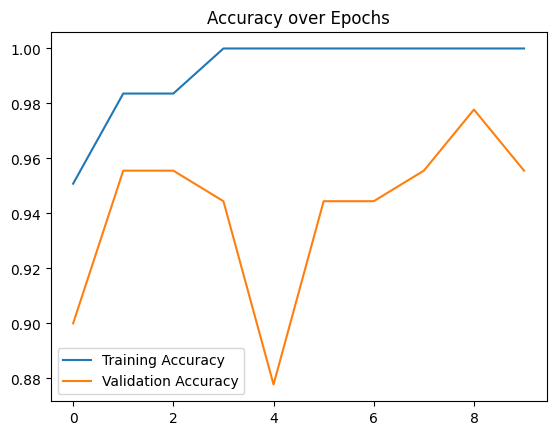

In [46]:
# Visualize accuracies

# converting Tensors to numpy arrays
train_accs = [acc.cpu().numpy() if hasattr(acc, "cpu") else acc for acc in train_accs]
val_accs = [acc.cpu().numpy() if hasattr(acc, "cpu") else acc for acc in val_accs]

plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

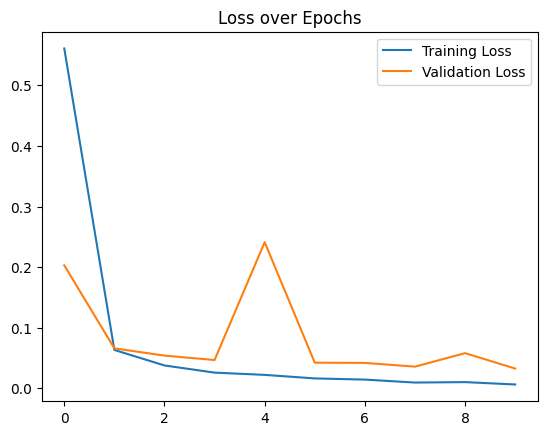

In [42]:
# Visualize losses

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

## Testing the Model

In [ ]:
# Loading the model

with open("blood_cell_classifier.pkl") as model_file:
    model = read_pickle(model_file)

## TODO : Saving the Model and Deploying Afterwards

In [ ]:
# Deploying the model with Streamlit

st.title("Blood Cell Classifier")
uploaded_file = st.file_uploader("Upload an Image")
if uploaded_file is not None:
    bytes_data = uploaded_file.getvalue()
    image = Image.open(io.BytesIO(bytes_data))
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    tensor = transform(image)

if st.button("Classify"):
    